In [15]:
!pip install shap

  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
%matplotlib inline


from tensorflow.keras import models, layers, utils, backend as K
import matplotlib.pyplot as plt

import shap

In [2]:
data = pd.read_csv('data_with_labels.csv')
data.head()

,State,Year,Slab,MultiBeam,GirderFloorBeamSystem,TeaBeam,BoxBeamMultiple,ArchDeck,Culvert,TrussThru,Frame,BoxBeamSingle,TrussDeck,Label
0,ALABAMA,1992,0.326781,0.257628,0.292597,0.417426,0.299461,0.850491,0.134380,0.887495,0.851453,0.014134,0.805998,1
1,ALASKA,1992,0.082470,0.268559,0.115272,0.172852,0.264056,0.141922,1.000000,0.494670,0.137405,0.000000,0.030212,1
2,ARIZONA,1992,0.183139,0.177047,0.096338,0.224856,0.137023,0.320507,0.061438,0.927453,0.197519,0.087231,0.413820,1
3,ARKANSAS,1992,0.170860,0.329185,0.222030,0.323595,0.192091,0.369497,0.054384,0.672889,0.131139,0.000000,0.586634,1
4,CALIFORNIA,1992,0.218799,0.497345,0.885631,0.344593,0.342176,0.623282,0.126319,0.941477,0.000000,0.000000,0.621819,1


In [3]:
X = np.array(data.iloc[:,2:-1])
X.shape

(1144, 11)

In [4]:
y = np.array(data['Label'])
y

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [5]:
# split data into test train set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
n_features = X_train.shape[1]

In [46]:
n_features = X_train.shape[1]

# DeepNN
### layer input
inputs = layers.Input(name="input", shape=(n_features,))
### hidden layer 1
h1 = layers.Dense(name="h1", units=int(round((n_features+1)/2)), activation='relu')(inputs)
h1 = layers.Dropout(name="drop1", rate=0.2)(h1)
### hidden layer 2
h2 = layers.Dense(name="h2", units=int(round((n_features+1)/2)), activation='relu')(h1)
h2 = layers.Dropout(name="drop2", rate=0.2)(h2)
### hidden layer 3
h3 = layers.Dense(name="h3", units=int(round((n_features+1)/2)), activation='relu')(h2)
h3 = layers.Dropout(name="drop3", rate=0.2)(h3)
### hidden layer 4
h4 = layers.Dense(name="h4", units=int(round((n_features+1)/2)), activation='relu')(h3)
h4 = layers.Dropout(name="drop4", rate=0.2)(h4)

### layer output
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h4)
model = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")
model.summary()

Model: "DeepNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 11)]              0         
                                                                 
 h1 (Dense)                  (None, 6)                 72        
                                                                 
 drop1 (Dropout)             (None, 6)                 0         
                                                                 
 h2 (Dense)                  (None, 6)                 42        
                                                                 
 drop2 (Dropout)             (None, 6)                 0         
                                                                 
 h3 (Dense)                  (None, 6)                 42        
                                                                 
 drop3 (Dropout)             (None, 6)                 0    

In [47]:
# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the neural network
model.compile(optimizer='adam', loss='mse', 
              metrics=['accuracy',F1])

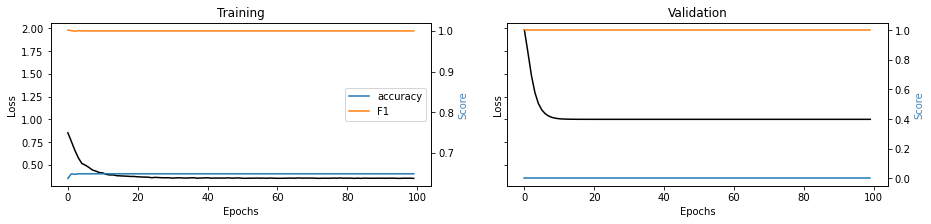

In [48]:
# train/validation
training = model.fit(x=X, y=y, batch_size=32, epochs=100, shuffle=True, verbose=0, validation_split=0.3)

# plot
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training.history['loss'], color='black')    
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training.history[metric], label=metric)    
    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training.history['val_loss'], color='black')    
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training.history['val_'+metric], label=metric)    
    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

# References

https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0